In [292]:
import numpy as np
import pandas as pd
from google.cloud import bigquery
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
import plotly.express as px
import db_dtypes
import bigframes.pandas as bpd
from IPython.display import display, HTML


def dps_new_f(city):

    query = """

    with dps_data as (
    SELECT   smto.entity_id
            ,smto.country_code
            ,smto.city_id
            ,smto.city_name
            ,CONCAT(smto.city_name , "-", "post") city_name_var
            ,smto.created_date_local
            ,date_trunc(created_date_local, ISOWEEK) week
            ,date_trunc(created_date_local, MONTH) month
            ,smto.customer_account_id
            ,smto.customer_first_order_date
            ,smto.order_id
            ,smto.dps_delivery_fee_eur
            ,smto.delivery_fee_eur
            ,smto.delivery_fee_local
            ,smto.dps_travel_time_fee_eur
            ,dps_standard_fee_eur
            ,vendor_funding_amount_local
            ,dps_last_non_zero_df_eur
            ,delivery_fee_vat_eur
            ,delivery_fee_vat_local
            ,smto.delivery_fee_option
            ,smto.priority_fee_eur
            ,smto.saver_discount_eur
            ,smto.gfv_eur
            ,smto.gfv_local
            ,smto.gmv_eur
            ,smto.gmv_local
            ,smto.profit_eur
            ,smto.profit_local
            ,smto.revenue_eur
            ,smto.revenue_local
            ,smto.mov_customer_fee_eur
            ,smto.service_fee_eur
            ,smto.dps_service_fee_eur
            ,smto.delivery_distance
            ,smto.delivery_costs_eur
            ,smto.delivery_costs_local
            ,smto.joker_vendor_fee_eur
            ,smto.is_sent
            ,smto.is_own_delivery
            ,smto.vertical_type
            ,(case when is_sent = TRUE then 1 else 0 end) completed_orders
            ,fully_loaded_gross_profit_eur
            ,smto.commission_eur
            ,smto.platform_order_code
            ,smto.has_new_customer_condition
            ,smto.new_customer_condition_type
    FROM `fulfillment-dwh-production.curated_data_shared.dps_sessions_mapped_to_orders` smto
    WHERE smto.entity_id = 'PO_FI'
        AND smto.created_date_local BETWEEN '2024-08-16' AND DATE_ADD('2024-08-16', INTERVAL 30 DAY)
        and has_new_customer_condition is true
        and new_customer_condition_type = 'TOTAL'
        AND city_name in (""" + city + """)
        AND is_own_delivery = TRUE
    ),
    voucher_data as (
    SELECT   o.global_entity_id
            ,order_id
            ,o.customer_account_id
            ,vouchers[SAFE_OFFSET(0)].voucher_code voucher_code
            ,vouchers[SAFE_OFFSET(0)].amount_eur voucher_amount_eur
    FROM `fulfillment-dwh-production.curated_data_shared_coredata_business.orders` o
    where global_entity_id='PO_FI'
    AND partition_date_local BETWEEN '2024-08-16' AND DATE_ADD('2024-08-16', INTERVAL 30 DAY)
    AND (vouchers[SAFE_OFFSET(0)].voucher_code in ('mieletön', 'tajuton','uskomaton','arena','huikea')
    OR vouchers[SAFE_OFFSET(0)].voucher_code like 'mieletön%' 
    OR vouchers[SAFE_OFFSET(0)].voucher_code like 'tajuton%'
    )
    )
    select dd.*
           ,vd.voucher_code
           ,vd.voucher_amount_eur
    from dps_data dd 
    left join voucher_data vd on vd.global_entity_id = dd.entity_id and vd.order_id = dd.platform_order_code

    """

    return query



def dps_all_f(city):

    query = """
    with details as (
    SELECT  smto.entity_id
            ,smto.country_code
            ,smto.city_id
            ,smto.city_name
            ,CONCAT(smto.city_name , "-", "post") city_name_var
            ,smto.created_date_local
            ,date_trunc(created_date_local, ISOWEEK) week
            ,date_trunc(created_date_local, MONTH) month
            ,smto.customer_account_id
            ,smto.customer_first_order_date
            ,smto.order_id
            ,smto.dps_delivery_fee_eur
            ,smto.delivery_fee_eur
            ,smto.delivery_fee_local
            ,dps_travel_time_fee_eur
            ,dps_standard_fee_eur
            ,vendor_funding_amount_local
            ,dps_last_non_zero_df_eur
            ,delivery_fee_vat_eur
            ,delivery_fee_vat_local
            ,smto.delivery_fee_option
            ,smto.priority_fee_eur
            ,smto.saver_discount_eur
            ,smto.gfv_eur
            ,smto.gfv_local
            ,smto.gmv_eur
            ,smto.gmv_local
            ,smto.profit_eur
            ,smto.profit_local
            ,smto.revenue_eur
            ,smto.revenue_local
            ,smto.mov_customer_fee_eur
            ,smto.service_fee_eur
            ,smto.dps_service_fee_eur
            ,smto.delivery_distance
            ,smto.delivery_costs_eur
            ,smto.delivery_costs_local
            ,smto.joker_vendor_fee_eur
            ,smto.is_sent
            ,smto.is_own_delivery
            ,smto.vertical_type
            ,(case when is_sent = TRUE then 1 else 0 end) completed_orders
            ,fully_loaded_gross_profit_eur
            ,smto.commission_eur
            ,smto.platform_order_code
            ,smto.has_new_customer_condition
            ,smto.new_customer_condition_type
    FROM `fulfillment-dwh-production.curated_data_shared.dps_sessions_mapped_to_orders` smto
    join
    (   SELECT  o.customer_account_id
        FROM `fulfillment-dwh-production.curated_data_shared.dps_sessions_mapped_to_orders` o
        WHERE o.entity_id = 'PO_FI'
            AND o.created_date_local BETWEEN '2024-08-16' AND DATE_ADD('2024-08-16', INTERVAL 30 DAY)
            and o.has_new_customer_condition is true
            and o.new_customer_condition_type = 'TOTAL'
            AND o.city_name in (""" + city + """)
            group by 1
    ) tm on tm.customer_account_id = smto.customer_account_id
    WHERE smto.created_date_local BETWEEN '2024-08-16' AND DATE_ADD('2024-08-16', INTERVAL 30 DAY)
    AND city_name in (""" + city + """)
    ),
    voucher_data as (
    SELECT  o.global_entity_id
            ,order_id
            ,o.customer_account_id
            ,vouchers[SAFE_OFFSET(0)].voucher_code voucher_code
            ,vouchers[SAFE_OFFSET(0)].amount_eur voucher_amount_eur
    FROM `fulfillment-dwh-production.curated_data_shared_coredata_business.orders` o
    where global_entity_id='PO_FI'
    AND partition_date_local BETWEEN '2024-08-16' AND DATE_ADD('2024-08-16', INTERVAL 30 DAY)
    AND (vouchers[SAFE_OFFSET(0)].voucher_code in ('mieletön', 'tajuton','uskomaton','arena','huikea')
    OR vouchers[SAFE_OFFSET(0)].voucher_code like 'mieletön%' 
    OR vouchers[SAFE_OFFSET(0)].voucher_code like 'tajuton%'
    )
    )
    select d.*
           ,vd.voucher_code
           ,vd.voucher_amount_eur
    from details d 
    left join voucher_data vd on vd.global_entity_id = d.entity_id and vd.order_id = d.platform_order_code
    """

    return query

    
def voucher_new_v(city):

    query = """
    SELECT   smto.entity_id
            ,smto.country_code
            ,smto.city_id
            ,smto.city_name
            ,CONCAT(smto.city_name , "-", "post") city_name_var
            ,smto.created_date_local
            ,date_trunc(created_date_local, ISOWEEK) week
            ,date_trunc(created_date_local, MONTH) month
            ,smto.customer_account_id
            ,smto.customer_first_order_date
            ,smto.order_id
            ,smto.dps_delivery_fee_eur
            ,smto.delivery_fee_eur
            ,smto.delivery_fee_local
            ,smto.dps_travel_time_fee_eur
            ,dps_standard_fee_eur
            ,vendor_funding_amount_local
            ,dps_last_non_zero_df_eur
            ,delivery_fee_vat_eur
            ,delivery_fee_vat_local
            ,smto.delivery_fee_option
            ,smto.priority_fee_eur
            ,smto.saver_discount_eur
            ,smto.gfv_eur
            ,smto.gfv_local
            ,smto.gmv_eur
            ,smto.gmv_local
            ,smto.profit_eur
            ,smto.profit_local
            ,smto.revenue_eur
            ,smto.revenue_local
            ,smto.mov_customer_fee_eur
            ,smto.service_fee_eur
            ,smto.dps_service_fee_eur
            ,smto.delivery_distance
            ,smto.delivery_costs_eur
            ,smto.delivery_costs_local
            ,smto.joker_vendor_fee_eur
            ,smto.is_sent
            ,smto.is_own_delivery
            ,smto.vertical_type
            ,(case when is_sent = TRUE then 1 else 0 end) completed_orders
            ,fully_loaded_gross_profit_eur
            ,smto.commission_eur
            ,smto.platform_order_code
            ,smto.has_new_customer_condition
            ,smto.new_customer_condition_type
            ,vd.vouchers[SAFE_OFFSET(0)].voucher_code
            ,vouchers[SAFE_OFFSET(0)].amount_eur voucher_amount_eur
    FROM `fulfillment-dwh-production.curated_data_shared.dps_sessions_mapped_to_orders` smto
    join `fulfillment-dwh-production.curated_data_shared_coredata_business.orders` vd on vd.global_entity_id = smto.entity_id and vd.order_id = smto.platform_order_code
    WHERE smto.entity_id = 'PO_FI'
        AND smto.created_date_local BETWEEN DATE_SUB(DATE '2024-08-16', INTERVAL 30 DAY) AND '2024-08-16'
        AND city_name in (""" + city + """)
        AND is_own_delivery = TRUE
        AND (vouchers[SAFE_OFFSET(0)].voucher_code in ('mieletön', 'tajuton','uskomaton','arena','huikea')
    OR vouchers[SAFE_OFFSET(0)].voucher_code like 'mieletön%' 
    OR vouchers[SAFE_OFFSET(0)].voucher_code like 'tajuton%'
    )
        AND vd.partition_date_local BETWEEN DATE_SUB(DATE '2024-08-16', INTERVAL 30 DAY) AND '2024-08-16'

    """

    return query


def voucher_all_v(city):

    query = """
    with details as (
    SELECT  smto.entity_id
            ,smto.country_code
            ,smto.city_id
            ,smto.city_name
            ,CONCAT(smto.city_name , "-", "post") city_name_var
            ,smto.created_date_local
            ,date_trunc(created_date_local, ISOWEEK) week
            ,date_trunc(created_date_local, MONTH) month
            ,smto.customer_account_id
            ,smto.customer_first_order_date
            ,smto.order_id
            ,smto.dps_delivery_fee_eur
            ,smto.delivery_fee_eur
            ,smto.delivery_fee_local
            ,dps_travel_time_fee_eur
            ,dps_standard_fee_eur
            ,vendor_funding_amount_local
            ,dps_last_non_zero_df_eur
            ,delivery_fee_vat_eur
            ,delivery_fee_vat_local
            ,smto.delivery_fee_option
            ,smto.priority_fee_eur
            ,smto.saver_discount_eur
            ,smto.gfv_eur
            ,smto.gfv_local
            ,smto.gmv_eur
            ,smto.gmv_local
            ,smto.profit_eur
            ,smto.profit_local
            ,smto.revenue_eur
            ,smto.revenue_local
            ,smto.mov_customer_fee_eur
            ,smto.service_fee_eur
            ,smto.dps_service_fee_eur
            ,smto.delivery_distance
            ,smto.delivery_costs_eur
            ,smto.delivery_costs_local
            ,smto.joker_vendor_fee_eur
            ,smto.is_sent
            ,smto.is_own_delivery
            ,smto.vertical_type
            ,(case when is_sent = TRUE then 1 else 0 end) completed_orders
            ,fully_loaded_gross_profit_eur
            ,smto.commission_eur
            ,smto.platform_order_code
            ,smto.has_new_customer_condition
            ,smto.new_customer_condition_type
    FROM `fulfillment-dwh-production.curated_data_shared.dps_sessions_mapped_to_orders` smto
    where smto.customer_account_id in 
    (
    SELECT  o.customer_account_id
    FROM `fulfillment-dwh-production.curated_data_shared_coredata_business.orders` o
    where global_entity_id='PO_FI'
    AND partition_date_local BETWEEN DATE_SUB(DATE '2024-08-16', INTERVAL 30 DAY) AND '2024-08-16'
     AND (vouchers[SAFE_OFFSET(0)].voucher_code in ('mieletön', 'tajuton','uskomaton','arena','huikea')
    OR vouchers[SAFE_OFFSET(0)].voucher_code like 'mieletön%' 
    OR vouchers[SAFE_OFFSET(0)].voucher_code like 'tajuton%'
    )
    group by 1
    )
    AND smto.created_date_local BETWEEN DATE_SUB(DATE '2024-08-16', INTERVAL 30 DAY) AND '2024-08-16'
    AND city_name in (""" + city + """)
    ),
    voucher_data as (
    SELECT  o.global_entity_id
            ,order_id
            ,o.customer_account_id
            ,vouchers[SAFE_OFFSET(0)].voucher_code
            ,vouchers[SAFE_OFFSET(0)].amount_eur voucher_amount_eur
    FROM `fulfillment-dwh-production.curated_data_shared_coredata_business.orders` o
    where global_entity_id='PO_FI'
    AND partition_date_local BETWEEN DATE_SUB(DATE '2024-08-16', INTERVAL 30 DAY) AND '2024-08-16'
    AND (vouchers[SAFE_OFFSET(0)].voucher_code in ('mieletön', 'tajuton','uskomaton','arena','huikea')
    OR vouchers[SAFE_OFFSET(0)].voucher_code like 'mieletön%' 
    OR vouchers[SAFE_OFFSET(0)].voucher_code like 'tajuton%'
    )
    )
    select dd.*
          ,vd.voucher_code
          ,vd.voucher_amount_eur
    from details dd 
    left join voucher_data as vd on vd.global_entity_id = dd.entity_id and vd.order_id = dd.platform_order_code
    """

    return query


def analyze_city_orders(df, order_thresholds=[1, 2, 3, 4]):
    
    df['foregone_delivery_fee'] = df['dps_standard_fee_eur'].where(
    (df['dps_delivery_fee_eur'] == 0) | (df['dps_delivery_fee_eur'].isnull()) & df['is_sent'] == True, 0)

    df['voucher_amount_eur'] = df['voucher_amount_eur'].where(df['is_sent'], 0)
    df['dps_delivery_fee_eur'] = df['dps_delivery_fee_eur'].where(df['is_sent'], 0)
    df['gfv_eur'] = df['gfv_eur'].where(df['is_sent'], 0)
    df['commission_eur'] = df['commission_eur'].where(df['is_sent'], 0)
    df['profit_eur'] = df['profit_eur'].where(df['is_sent'], 0)
    df['revenue_eur'] = df['revenue_eur'].where(df['is_sent'], 0)
    df['fully_loaded_gross_profit_eur'] = df['fully_loaded_gross_profit_eur'].where(df['is_sent'], 0)
    df['delivery_distance'] = df['delivery_distance'].where(df['is_sent'], 0)
    df['delivery_costs_eur'] = df['delivery_costs_eur'].where(df['is_sent'], 0)

    grouped_data_post = df.groupby('city_name_var').agg({
        'platform_order_code': 'nunique',
        'customer_account_id': 'nunique',
        'completed_orders': 'sum',
        'dps_delivery_fee_eur': ['mean','sum'],
        'gfv_eur': ['mean','sum'],
        'voucher_amount_eur': ['mean', 'sum'],
        'commission_eur': ['mean','sum'],
        'profit_eur': ['mean','sum'],
        'revenue_eur': ['mean','sum'],
        'fully_loaded_gross_profit_eur': ['mean','sum'],
        'delivery_distance': ['mean','sum'],
        'delivery_costs_eur': ['mean','sum'],
        'foregone_delivery_fee': ['mean','sum']
    }).reset_index()

    grouped_data_post.columns = ['_'.join(col).strip() if isinstance(col, tuple) else col for col in grouped_data_post.columns]

    grouped_data_post = grouped_data_post.rename(columns={
        'city_name_var_':'city_name_var',
        'platform_order_code_nunique': 'total_orders',
        'customer_account_id_nunique': 'total_users',
        'completed_orders_sum':'total_completed_orders',
        'dps_delivery_fee_eur_mean': 'actual_delivery_fee_per_order',
        'dps_delivery_fee_eur_sum': 'total_actual_delivery_fee',
        'voucher_amount_eur_mean':'voucher_eur_per_order',
        'voucher_amount_eur_sum': 'total_voucher_eur',
        'gfv_eur_mean':'gfv_eur_per_order',
        'gfv_eur_sum':'total_gfv_eur',
        'commission_eur_mean':'commission_eur_per_order',
        'commission_eur_sum':'total_commission_eur',
        'profit_eur_mean':'profit_eur_per_order',
        'profit_eur_sum':'total_profit_eur',
        'revenue_eur_mean':'revenue_eur_per_order',
        'revenue_eur_sum':'total_revenue_eur',
        'fully_loaded_gross_profit_eur_mean':'fully_loaded_gross_profit_eur_per_order',
        'fully_loaded_gross_profit_eur_sum' : 'total_fully_loaded_gross_profit_eur',
        'delivery_distance_mean': 'delivery_distance_per_order',
        'delivery_distance_sum':'total_delivery_distance',
        'delivery_costs_eur_mean': 'delivery_costs_eur_per_order',
        'delivery_costs_eur_sum': 'total_delivery_costs_eur',
        'foregone_delivery_fee_mean': 'forgone_delivery_fee_per_order',
        'foregone_delivery_fee_sum': 'total_foregone_delivery_fee',
        })

    
    voucher_counts = df[df['voucher_code'].notnull()].groupby('city_name_var')['platform_order_code'].nunique().reset_index()
    voucher_counts = voucher_counts.rename(columns={'platform_order_code': 'voucher_based_orders'})
    
    grouped_data_post = grouped_data_post.merge(voucher_counts, on='city_name_var', how='left').fillna(0)

    grouped_data_post['c_orders_per_user'] = grouped_data_post['total_completed_orders'] / grouped_data_post['total_users']
    grouped_data_post['orders_per_user'] = grouped_data_post['total_orders'] / grouped_data_post['total_users']
    grouped_data_post['total_acquistion_cost'] = grouped_data_post['total_foregone_delivery_fee'] + grouped_data_post['total_voucher_eur']
    grouped_data_post['acquistion_cost_per_order'] =  grouped_data_post['total_acquistion_cost'] / grouped_data_post['total_orders']

    order_counts = df.groupby(['city_name_var', 'customer_account_id']).agg({'platform_order_code': 'nunique'}).reset_index()

    def calculate_share_by_order_threshold(order_counts, city, threshold):
        city_data = order_counts[order_counts['city_name_var'] == city]
        total_customers = city_data['customer_account_id'].nunique()
        customers_above_threshold = city_data[city_data['platform_order_code'] > threshold]['customer_account_id'].nunique()
        if total_customers == 0:
            return 0, 0
        share_above_threshold = customers_above_threshold / total_customers
        return round(share_above_threshold, 2), customers_above_threshold

    for threshold in order_thresholds:
        grouped_data_post[f'customers_gt_{threshold}_orders_share'] = grouped_data_post['city_name_var'].apply(
            lambda city: calculate_share_by_order_threshold(order_counts, city, threshold)
        )

    columns_to_sum = ['total_orders', 'total_users', 'total_completed_orders', 'voucher_based_orders', 'total_foregone_delivery_fee','total_acquistion_cost']
    total_row = grouped_data_post[columns_to_sum].sum()

    # Perform calculations but do not store in total_row for display purposes
    total_orders = grouped_data_post['total_orders'].sum()
    total_users = grouped_data_post['total_users'].sum()
    total_completed_orders = grouped_data_post['total_completed_orders'].sum()
    total_foregone_delivery_fee = grouped_data_post['total_foregone_delivery_fee'].sum()
    total_actual_delivery_fee = grouped_data_post['total_actual_delivery_fee'].sum()
    total_voucher_eur = grouped_data_post['total_voucher_eur'].sum()
    total_gfv_eur = grouped_data_post['total_gfv_eur'].sum()
    total_commission_eur = grouped_data_post['total_commission_eur'].sum()
    total_profit_eur = grouped_data_post['total_profit_eur'].sum()
    total_revenue_eur = grouped_data_post['total_revenue_eur'].sum()
    total_fully_loaded_gross_profit_eur = grouped_data_post['total_fully_loaded_gross_profit_eur'].sum()
    total_delivery_distance = grouped_data_post['total_delivery_distance'].sum()
    total_delivery_costs_eur = grouped_data_post['total_delivery_costs_eur'].sum()
    total_acquistion_cost_eur = grouped_data_post['total_acquistion_cost'].sum()

    # Use these calculations for other metrics but don't store them in total_row if not needed
    orders_per_user = total_orders / total_users
    c_orders_per_user = total_completed_orders / total_users
    forgone_delivery_fee_per_order = total_foregone_delivery_fee / total_completed_orders
    actual_delivery_fee_per_order = total_actual_delivery_fee / total_completed_orders
    voucher_eur_per_order = total_voucher_eur / total_completed_orders
    gfv_eur_per_order = total_gfv_eur / total_completed_orders
    commission_eur_per_order =  total_commission_eur / total_completed_orders
    profit_eur_per_order = total_profit_eur / total_completed_orders
    revenue_eur_per_order = total_revenue_eur / total_completed_orders
    fully_loaded_gross_profit_eur_per_order = total_fully_loaded_gross_profit_eur / total_completed_orders
    delivery_distance_per_order = total_delivery_distance / total_completed_orders
    delivery_costs_eur_per_order = total_delivery_costs_eur / total_completed_orders
    acquistion_cost_per_order = total_acquistion_cost_eur / total_completed_orders

    # Now assign only necessary calculated values to the final total_row
    total_row['orders_per_user'] = orders_per_user
    total_row['c_orders_per_user'] = c_orders_per_user
    total_row['forgone_delivery_fee_per_order'] = forgone_delivery_fee_per_order
    total_row['actual_delivery_fee_per_order'] = actual_delivery_fee_per_order
    total_row['voucher_eur_per_order'] = voucher_eur_per_order
    total_row['total_voucher_eur'] = total_voucher_eur
    total_row['gfv_eur_per_order'] = gfv_eur_per_order
    total_row['commission_eur_per_order'] = commission_eur_per_order
    total_row['profit_eur_per_order'] = profit_eur_per_order
    total_row['revenue_eur_per_order'] = revenue_eur_per_order
    total_row['delivery_distance_per_order'] = delivery_distance_per_order
    total_row['delivery_costs_eur_per_order'] = delivery_costs_eur_per_order
    total_row['fully_loaded_gross_profit_eur_per_order'] = fully_loaded_gross_profit_eur_per_order
    total_row['acquistion_cost_per_order'] = acquistion_cost_per_order
    total_row['customers_gt_1_orders_share'] = None
    total_row['customers_gt_2_orders_share'] = None
    total_row['customers_gt_3_orders_share'] = None
    total_row['customers_gt_4_orders_share'] = None

    total_row['city_name_var'] = 'Total'

    # Convert the total_row to a DataFrame and append it
    total_row = pd.DataFrame([total_row])

    grouped_data_post = grouped_data_post[['city_name_var','total_users','total_orders','total_completed_orders','voucher_based_orders','orders_per_user','c_orders_per_user',
    'actual_delivery_fee_per_order','forgone_delivery_fee_per_order','voucher_eur_per_order','acquistion_cost_per_order','total_foregone_delivery_fee','total_voucher_eur','total_acquistion_cost','gfv_eur_per_order','commission_eur_per_order','revenue_eur_per_order','delivery_costs_eur_per_order','profit_eur_per_order','fully_loaded_gross_profit_eur_per_order','delivery_distance_per_order',
  'customers_gt_1_orders_share','customers_gt_2_orders_share','customers_gt_3_orders_share','customers_gt_4_orders_share']]
    

    grouped_data_post = pd.concat([grouped_data_post, total_row], ignore_index=True)

    return grouped_data_post.round(2).set_index('city_name_var').T

def handle_customer_first_order_date(df):
    df['customer_first_order_date'] = pd.to_datetime(df['customer_first_order_date'], errors='coerce')
    df['customer_first_order_date'] = df['customer_first_order_date'].replace(pd.Timestamp('0001-01-01 00:00:00+00:00'), pd.NaT)
    return df

def check_first_order_before_intervention(df, intervention_date='2024-08-06'):
    return "yes" if (df['customer_first_order_date'] < intervention_date).any() else "no"

def check_duplicate_orders(df):
    duplicate_users = df[df.duplicated(subset='customer_account_id')]['customer_account_id'].nunique()
    return duplicate_users

def check_zero_delivery_fee(df):
    zero_count = ((df['dps_delivery_fee_eur'] == 0) | (df['dps_delivery_fee_eur'].isna())).sum()
    total_count = len(df['platform_order_code'])
    percentage_zeros = (zero_count / total_count) * 100
    return percentage_zeros

def check_same_users(df1, df2):
    
    return df2['customer_account_id'].isin(df1['customer_account_id']).all()

def count_orders_with_vouchers_free_delivery(df):
    
    return df[(~df['voucher_code'].isna()) & (~df['dps_delivery_fee_eur'].isna())]['platform_order_code'].nunique()


def plot_cumulative_orders_by_city(df):
    
    df = df[df['is_sent'] == True]
    df['created_date_local'] = pd.to_datetime(df['created_date_local'])
    
    df['first_order_date'] = df.groupby('customer_account_id')['created_date_local'].transform('min')
    
    df['days_since_first_order'] = (df['created_date_local'] - df['first_order_date']).dt.days
    
    for city in df['city_id'].unique():
        plt.figure(figsize=(10, 6))
        city_data = df[df['city_id'] == city]
        agg_city_data = city_data.groupby('days_since_first_order').size().cumsum()
        
        plt.plot(agg_city_data.index, agg_city_data.values, marker='o', label=f'City {city}', color='red')
        
        plt.xlabel('Days since first order')
        plt.ylabel('Cumulative orders (city)')
        plt.title(f'Cumulative Orders over Time for City {city}')
        plt.grid(True)
        plt.legend()
        
        plt.show()

    plt.figure(figsize=(10, 6))
    agg_data = df.groupby('days_since_first_order').size().cumsum()
    
    plt.plot(agg_data.index, agg_data.values, marker='o', color='red', linewidth=2, label='All Cities (Aggregated)')
    
    plt.xlabel('Days since first order')
    plt.ylabel('Cumulative orders (all users)')
    plt.title('Cumulative Orders over Time for All Cities (Aggregated)')
    plt.grid(False)
    plt.legend()

    plt.show()

def create_retention_d(df):
   
    post_inter_df = df[df['is_sent'] == True].copy()

    post_inter_df['first_order_date'] = post_inter_df.groupby('customer_account_id')['created_date_local'].transform('min')

    post_inter_df['week_diff'] = ((post_inter_df['created_date_local'] - post_inter_df['first_order_date']).dt.days // 7)

    total_users = post_inter_df['customer_account_id'].nunique()

    retention_df = post_inter_df.groupby('week_diff').agg(
        users_retained=('customer_account_id', 'nunique'),
        orders_made=('completed_orders', 'sum'),
        profit_made=('profit_eur', 'sum'),
        flgp=('fully_loaded_gross_profit_eur', 'sum')
    )

    retention_df['retention_rate'] = (retention_df['users_retained'] / total_users) * 100
    retention_df['orders_per_user'] = (retention_df['orders_made'] / retention_df['users_retained'])
    retention_df['profit_per_order'] = (retention_df['profit_made'] / retention_df['orders_made'])
    retention_df['flgpo'] = (retention_df['flgp'] / retention_df['orders_made'])

    x = retention_df.index
    y = retention_df['retention_rate']

    plt.figure(figsize=(10, 6))
    plt.plot(x, y, marker='o', color='red', linestyle='-')

    for i in range(len(x)):
        plt.text(i, y[i] + 1.5, round(y[i], 2), ha='center', va='bottom')

    plt.xlabel('Weeks Since First Order', fontsize=12)
    plt.ylabel('Retention Rate (%)', fontsize=12)
    plt.title('Week-over-Week User Retention', fontsize=14)
    plt.grid(False)
    plt.xticks(retention_df.index)
    plt.show()

    retention_df = retention_df.round(2).reset_index()

    return retention_df

def estimated_retained_customers(df, r_df, week_diff_range=5):
  
    weekly_new_customers = df.groupby('week').agg(
        new_customers=('customer_account_id', lambda x: np.sum((df.loc[x.index, 'has_new_customer_condition'] == True) &
                                                               (df.loc[x.index, 'new_customer_condition_type'] == 'TOTAL')))
    ).reset_index()

    long_form_retained_customers = pd.DataFrame()

    # Loop over the week_diff range to calculate the retention impact for each week
    for i in range(0, week_diff_range):
        temp_df = weekly_new_customers.copy()
        temp_df['week_diff'] = i
        temp_df['Retained_Customers'] = round(
            temp_df['new_customers'] * ((r_df.loc[r_df['week_diff'] == i, 'retention_rate'].values[0]) / 100), 0
        )
        temp_df['Orders_per_User'] = r_df.loc[r_df['week_diff'] == i, 'orders_per_user'].values[0]
        temp_df['Profit_per_Order'] = r_df.loc[r_df['week_diff'] == i, 'profit_per_order'].values[0]
        temp_df['flgp_per_order'] = r_df.loc[r_df['week_diff'] == i, 'flgpo'].values[0]

        # Calculate total orders, total profit, and FLGP
        temp_df['Total_Orders'] = temp_df['Retained_Customers'] * temp_df['Orders_per_User']
        temp_df['Total_Profit'] = temp_df['Total_Orders'] * temp_df['Profit_per_Order']
        temp_df['FLGP'] = temp_df['Total_Orders'] * temp_df['flgp_per_order']

        # Concatenate results
        long_form_retained_customers = pd.concat([long_form_retained_customers, temp_df], ignore_index=True)

    # Select the relevant columns
    long_form_retained_customers = long_form_retained_customers[['week', 'new_customers', 'week_diff', 'Retained_Customers',
                                                                 'Orders_per_User', 'Profit_per_Order', 'flgp_per_order',
                                                                 'Total_Orders', 'Total_Profit', 'FLGP']]

    # Convert week column to datetime and calculate final week
    long_form_retained_customers['week'] = pd.to_datetime(long_form_retained_customers['week'])
    long_form_retained_customers['final_week'] = long_form_retained_customers['week'] + pd.to_timedelta(long_form_retained_customers['week_diff'] * 7, unit='D')

    return long_form_retained_customers



def impact_summary(df):
    
    # Group by 'final_week' and calculate aggregate and incremental metrics
    total_impact = df.groupby('final_week').agg(
        Total_Orders=('Total_Orders', 'sum'), 
        Total_Profit=('Total_Profit', 'sum'),
        Total_FLGP=('FLGP', 'sum'),
        incremental_orders=('Total_Orders', lambda x: x[df.loc[x.index, 'week_diff'].isin([1, 2, 3, 4, 5])].sum()),
        incremental_profit=('Total_Profit', lambda x: x[df.loc[x.index, 'week_diff'].isin([1, 2, 3, 4, 5])].sum()),
        incremental_flgp=('FLGP', lambda x: x[df.loc[x.index, 'week_diff'].isin([1, 2, 3, 4, 5])].sum())
    ).reset_index()
    
    # Calculate cumulative values
    total_impact['total_orders_cum'] = total_impact['Total_Orders'].cumsum()
    total_impact['total_profit_cum'] = total_impact['Total_Profit'].cumsum()
    total_impact['total_flgp_cum'] = total_impact['Total_FLGP'].cumsum()
    
    return total_impact


def impact_summary_w_cost(df, df1):

    cost_df = df.copy()

    cost_df['foregone_delivery_fee'] = cost_df.apply(
        lambda row: row['dps_standard_fee_eur'] if row['dps_delivery_fee_eur'] == 0 or pd.isnull(row['dps_delivery_fee_eur']) else 0,
        axis=1
    )

    w_cost_df = cost_df.groupby('week').agg({
        'foregone_delivery_fee': 'sum',
        'voucher_amount_eur': 'sum'
    }).reset_index()

    w_cost_df['total_cost'] = w_cost_df['foregone_delivery_fee'] + w_cost_df['voucher_amount_eur'] 

    w_cost_df.rename(columns={'week': 'final_week'}, inplace=True)

    w_cost_df['final_week'] = pd.to_datetime(w_cost_df['final_week'])
    df1['final_week'] = pd.to_datetime(df1['final_week'])

    final_df = pd.merge(df1, w_cost_df, on='final_week', how='left')

    final_df['total_cost'] = final_df['total_cost'].astype(float)
    final_df.fillna(0, inplace=True)

    final_df['total_cost_cum'] = final_df['total_cost'].cumsum()

    return final_df



def plot_cumulative_incremental_profit(df):
    plt.figure(figsize=(10, 6))

    bars1 = plt.bar(df['final_week'], df['total_flgp_cum'], label='Cumulative Profit', width=4, align='center', color='lightgrey')

    bars2 = plt.bar(df['final_week'], df['incremental_profit'], label='Incremental Profit', width=4, align='center',
                    bottom=np.where(df['total_flgp_cum'] >= 0, df['total_flgp_cum'], df['total_flgp_cum']),
                    color='red')

    for i, bar in enumerate(bars1):
        height = bar.get_height()

        if not np.isnan(height):
            if height < 0:
                plt.text(bar.get_x() + bar.get_width() / 2.0, height - 300, f'{int(height)}',
                         ha='center', va='top', color='black')
            else:
                plt.text(bar.get_x() + bar.get_width() / 2.0, height - 300, f'{int(height)}',
                         ha='center', va='top', color='black')

    for i, bar in enumerate(bars2):
        height = bar.get_height()
        bottom = bar.get_y()

        if not np.isnan(height):
            plt.text(bar.get_x() + bar.get_width() / 2, bottom + height / 3, f'{int(abs(height))}',
                     ha='center', va='center', color='black')

    plt.title('Cumulative and Incremental Profit Over Time')
    plt.xlabel('Week')
    plt.ylabel('Profit (€)')

    plt.xticks(df['final_week'])

    ymin = df[['total_flgp_cum', 'incremental_profit']].min().min() - 5000
    ymax = df[['total_flgp_cum', 'incremental_profit']].max().max() + 5000

    plt.ylim(ymin, ymax)
    plt.yticks(np.arange(np.floor(ymin / 5000) * 5000, np.ceil(ymax / 5000) * 5000, 5000))

    plt.legend()
    plt.tight_layout()
    plt.show()


def plot_cumulative_incremental_orders(df):
    plt.figure(figsize=(10, 6))

    bars1 = plt.bar(df['final_week'], df['total_orders_cum'], width=4, align='center', label='Cumulative Orders', color='lightgrey')

    bars2 = plt.bar(df['final_week'], df['incremental_orders'], width=4, align='center', label='Incremental Orders', 
                    bottom=df['total_orders_cum'] - df['incremental_orders'], color='red')

    for i, bar in enumerate(bars1):
        height = bar.get_height()
        incremental_height = df['incremental_orders'].iloc[i]

        if not np.isnan(height) and not np.isnan(incremental_height):
            plt.text(bar.get_x() + bar.get_width() / 2.0, height - incremental_height - 50,
                     f'{int(height)}', ha='center', va='top', color='black')

    for i, bar in enumerate(bars2):
        height = bar.get_height()
        bottom = bar.get_y()

        if not np.isnan(height):
            plt.text(bar.get_x() + bar.get_width() / 2.0, bottom + height / 2, f'{int(height)}', ha='center', va='center', color='black')

    plt.title('Cumulative and Incremental Orders Over Time')
    plt.xlabel('Week')
    plt.ylabel('Orders')

    plt.xticks(df['final_week'])

    plt.legend()
    plt.tight_layout() 
    plt.show()




In [293]:
# define a few things (project id, start date etc.)
project_id = "logistics-customer-staging"
client = bigquery.Client(project = project_id)

/Users/shazeb.asad/global_pricing/.venv/lib/python3.12/site-packages/google/auth/_default.py:76: UserWarning: Your application has authenticated using end user credentials from Google Cloud SDK without a quota project. You might receive a "quota exceeded" or "API not enabled" error. See the following page for troubleshooting: https://cloud.google.com/docs/authentication/adc-troubleshooting/user-creds. 
  warnings.warn(_CLOUD_SDK_CREDENTIALS_WARNING)


In [294]:
#city = ('Tampere','Turku')
city = ('Helsinki','Oulu')
city_str = ",".join([f"'{c}'" for c in city])

dps_new = client.query(dps_new_f(city_str)).to_dataframe()
dps_all = client.query(dps_all_f(city_str)).to_dataframe()

In [295]:
### DPS ANALYSIS NEW CUSTOMERS ###

## missing values ##
missing_value_before = dps_new.isna().sum()
missing_columns_before = missing_value_before[missing_value_before != 0]

print(missing_columns_before)

columns_to_fill = ['voucher_amount_eur','delivery_costs_eur','delivery_distance']

dps_new[columns_to_fill] = dps_new[columns_to_fill].fillna(0)

missing_value_after = dps_new.isna().sum()
missing_columns_after =  missing_value_after[missing_value_after != 0]

print(missing_columns_after)


## summary of first order data ###

# first order ##

dps_new = handle_customer_first_order_date(dps_new)

## DATA CHECKS ##
print(f'Are there any users with orders with 0 DPS delivery fee before the intervention date?', {check_first_order_before_intervention(dps_new)})
print(f'Are there any users with multiple orders as characterized as new customer first time order?', {check_duplicate_orders(dps_new)})
print(f'Are there any orders with 0 delivery fee which will be used to assess the cost?',{check_zero_delivery_fee(dps_new)})
print(F'How many orders had both free delivery and vouchers?',{count_orders_with_vouchers_free_delivery(dps_new)})


### convert numeric data to float ###

columns_to_convert = ['dps_delivery_fee_eur',
       'delivery_fee_eur', 'delivery_fee_local', 'dps_travel_time_fee_eur',
       'dps_standard_fee_eur', 'vendor_funding_amount_local',
       'dps_last_non_zero_df_eur', 'delivery_fee_vat_eur',
       'delivery_fee_vat_local', 'delivery_fee_option', 'priority_fee_eur',
       'saver_discount_eur', 'gfv_eur', 'gfv_local', 'gmv_eur', 'gmv_local',
       'profit_eur', 'profit_local', 'revenue_eur', 'revenue_local',
       'mov_customer_fee_eur', 'service_fee_eur', 'dps_service_fee_eur',
       'delivery_distance', 'delivery_costs_eur', 'delivery_costs_local',
       'joker_vendor_fee_eur','completed_orders', 'fully_loaded_gross_profit_eur', 'commission_eur',
        'voucher_amount_eur']

dps_new[columns_to_convert] = dps_new[columns_to_convert].apply(pd.to_numeric, errors='coerce').astype(float)

analyze_city_orders(dps_new)


customer_first_order_date      4042
dps_standard_fee_eur             88
vendor_funding_amount_local    4803
delivery_fee_option              36
saver_discount_eur             4803
delivery_distance                81
delivery_costs_eur               34
delivery_costs_local             34
voucher_code                   3456
voucher_amount_eur             3462
dtype: int64
customer_first_order_date      4042
dps_standard_fee_eur             88
vendor_funding_amount_local    4803
delivery_fee_option              36
saver_discount_eur             4803
delivery_costs_local             34
voucher_code                   3456
dtype: int64
Are there any users with orders with 0 DPS delivery fee before the intervention date? {'no'}
Are there any users with multiple orders as characterized as new customer first time order? {68}
Are there any orders with 0 delivery fee which will be used to assess the cost? {95.46117010201957}
How many orders had both free delivery and vouchers? {1347}


city_name_var,Helsinki-post,Oulu-post,Total
total_users,3829.0,886.0,4715.0
total_orders,3892.0,911.0,4803.0
total_completed_orders,3802.0,890.0,4692.0
voucher_based_orders,1079.0,268.0,1347.0
orders_per_user,1.02,1.03,1.02
c_orders_per_user,0.99,1.0,1.0
actual_delivery_fee_per_order,0.26,0.28,0.27
forgone_delivery_fee_per_order,3.45,3.65,3.54
voucher_eur_per_order,3.92,4.06,4.04
acquistion_cost_per_order,7.37,7.51,7.57


In [296]:
### DPS ANALYSIS ALL CUSTOMERS ###

## missing values ##
missing_value_before = dps_all.isna().sum()
missing_columns_before = missing_value_before[missing_value_before != 0]

print(missing_columns_before)

columns_to_fill = ['voucher_amount_eur','delivery_costs_eur','delivery_distance']

dps_all[columns_to_fill] = dps_all[columns_to_fill].fillna(0)

missing_value_after = dps_all.isna().sum()
missing_columns_after =  missing_value_after[missing_value_after != 0]

print(missing_columns_after)


## summary of first order data ###

# first order ##

dps_all = handle_customer_first_order_date(dps_all)

## DATA CHECKS ##
print(f'Are there any users with orders with 0 DPS delivery fee before the intervention date?', {check_first_order_before_intervention(dps_all)})
print(f'Are there any orders with 0 delivery fee which will be used to assess the cost?',{check_zero_delivery_fee(dps_all)})
print(F'How many orders had both free delivery and vouchers?',{count_orders_with_vouchers(dps_all)})


### convert numeric data to float ###

columns_to_convert = ['dps_delivery_fee_eur',
       'delivery_fee_eur', 'delivery_fee_local', 'dps_travel_time_fee_eur',
       'dps_standard_fee_eur', 'vendor_funding_amount_local',
       'dps_last_non_zero_df_eur', 'delivery_fee_vat_eur',
       'delivery_fee_vat_local', 'delivery_fee_option', 'priority_fee_eur',
       'saver_discount_eur', 'gfv_eur', 'gfv_local', 'gmv_eur', 'gmv_local',
       'profit_eur', 'profit_local', 'revenue_eur', 'revenue_local',
       'mov_customer_fee_eur', 'service_fee_eur', 'dps_service_fee_eur',
       'delivery_distance', 'delivery_costs_eur', 'delivery_costs_local',
       'joker_vendor_fee_eur','completed_orders', 'fully_loaded_gross_profit_eur', 'commission_eur',
        'voucher_amount_eur']

dps_all[columns_to_convert] = dps_all[columns_to_convert].apply(pd.to_numeric, errors='coerce').astype(float)

dps_post = dps_all[(dps_all['has_new_customer_condition'] == False) & (dps_all['new_customer_condition_type'] != 'TOTAL')]

analyze_city_orders(dps_post)

customer_first_order_date      4140
dps_delivery_fee_eur              4
dps_travel_time_fee_eur           4
dps_standard_fee_eur           1291
vendor_funding_amount_local    6213
dps_last_non_zero_df_eur          4
delivery_fee_option              53
saver_discount_eur             6244
dps_service_fee_eur               4
delivery_distance               100
delivery_costs_eur               43
delivery_costs_local             43
new_customer_condition_type    1432
voucher_code                   4896
voucher_amount_eur             4902
dtype: int64
customer_first_order_date      4140
dps_delivery_fee_eur              4
dps_travel_time_fee_eur           4
dps_standard_fee_eur           1291
vendor_funding_amount_local    6213
dps_last_non_zero_df_eur          4
delivery_fee_option              53
saver_discount_eur             6244
dps_service_fee_eur               4
delivery_costs_local             43
new_customer_condition_type    1432
voucher_code                   4896
dtype: int64
Ar

/var/folders/7c/hjrbzbpn61jgnsn14y5f3l7c0000gq/T/ipykernel_30934/189176572.py:351: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['foregone_delivery_fee'] = df['dps_standard_fee_eur'].where(
/var/folders/7c/hjrbzbpn61jgnsn14y5f3l7c0000gq/T/ipykernel_30934/189176572.py:354: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['voucher_amount_eur'] = df['voucher_amount_eur'].where(df['is_sent'], 0)
/var/folders/7c/hjrbzbpn61jgnsn14y5f3l7c0000gq/T/ipykernel_30934/189176572.py:355: SettingWithCopyWarning: 
A valu

city_name_var,Helsinki-post,Oulu-post,Total
total_users,679.0,142.0,821.0
total_orders,1197.0,235.0,1432.0
total_completed_orders,1171.0,232.0,1403.0
voucher_based_orders,1.0,0.0,1.0
orders_per_user,1.76,1.65,1.74
c_orders_per_user,1.72,1.63,1.71
actual_delivery_fee_per_order,2.73,2.67,2.77
forgone_delivery_fee_per_order,0.42,0.73,0.48
voucher_eur_per_order,0.01,0.0,0.01
acquistion_cost_per_order,0.44,0.69,0.49


/var/folders/7c/hjrbzbpn61jgnsn14y5f3l7c0000gq/T/ipykernel_30934/189176572.py:534: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['created_date_local'] = pd.to_datetime(df['created_date_local'])
/var/folders/7c/hjrbzbpn61jgnsn14y5f3l7c0000gq/T/ipykernel_30934/189176572.py:536: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['first_order_date'] = df.groupby('customer_account_id')['created_date_local'].transform('min')
/var/folders/7c/hjrbzbpn61jgnsn14y5f3l7c0000gq/T/ipykernel_30934/189176572.py:538: Setti

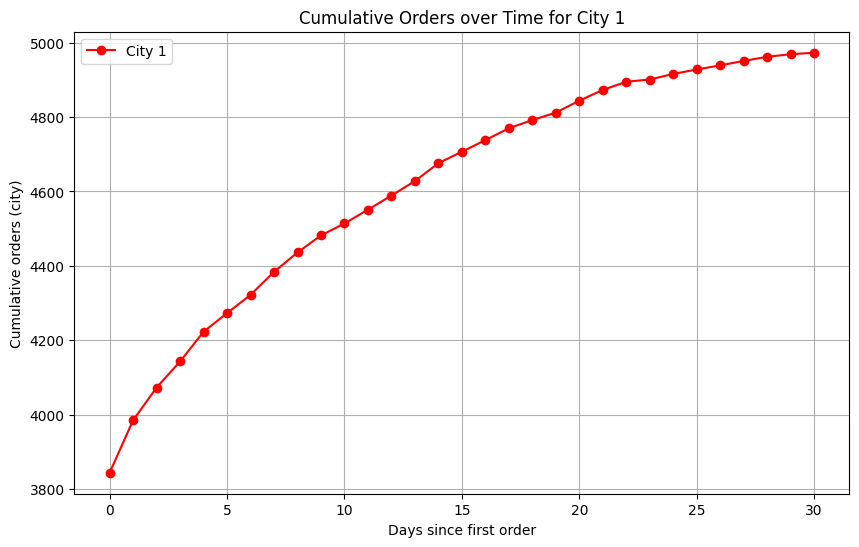

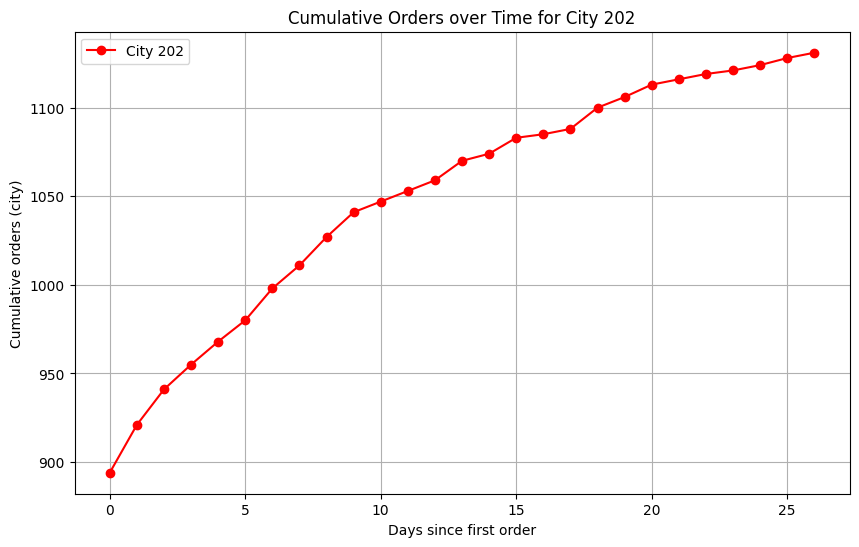

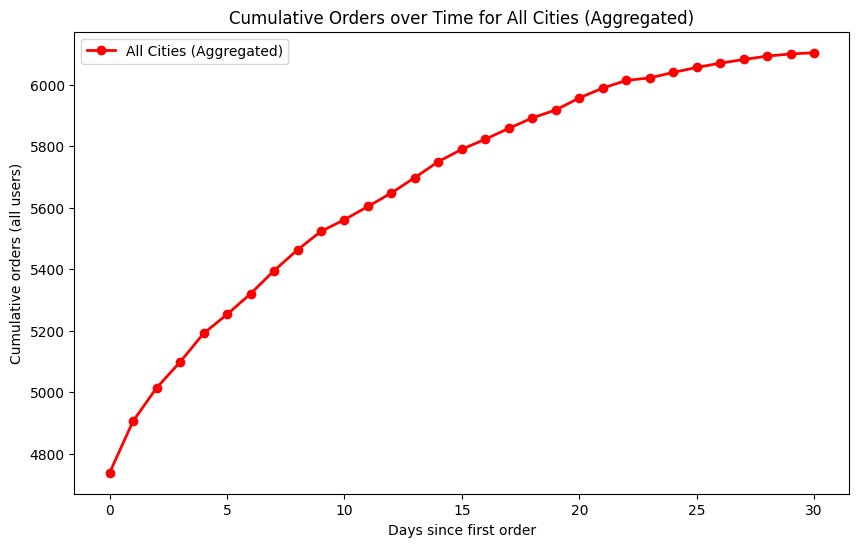

In [297]:
plot_cumulative_orders_by_city(dps_all)

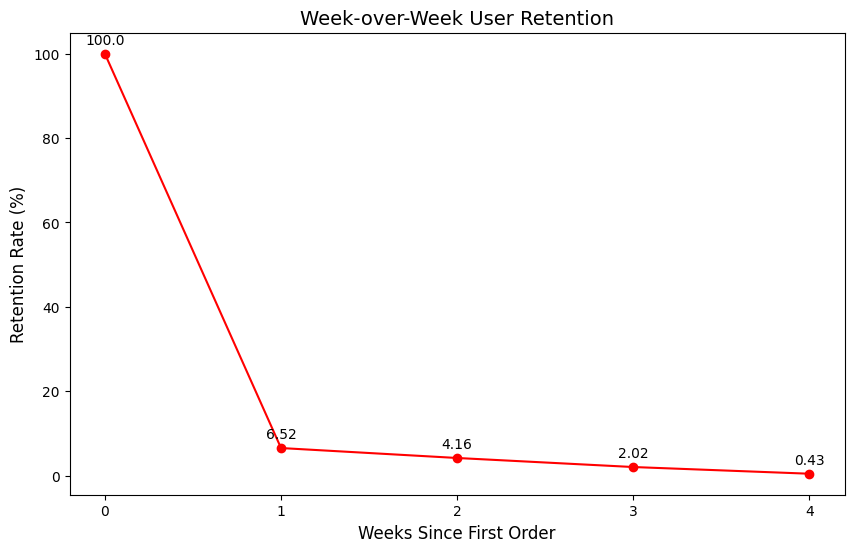

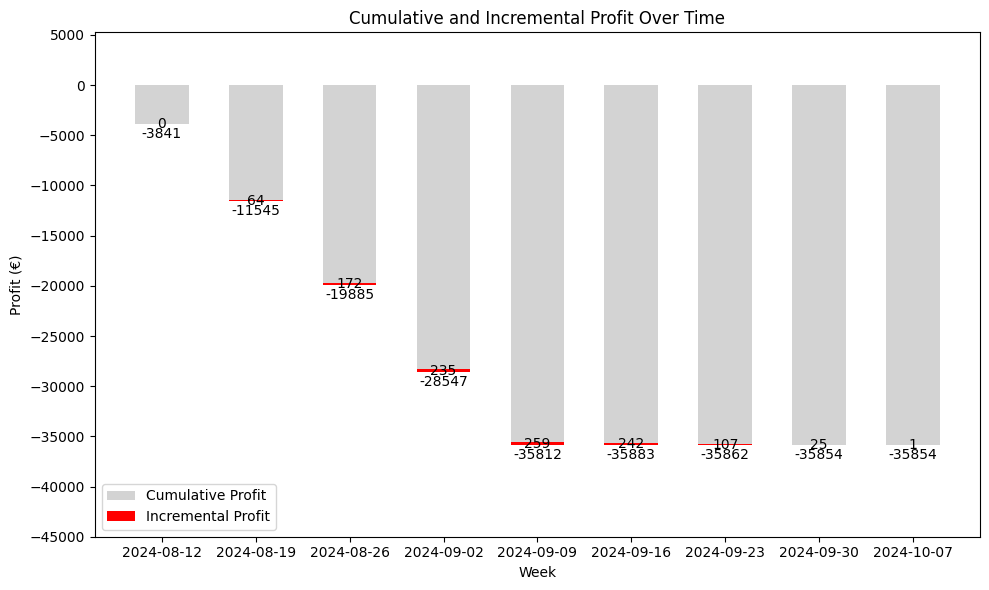

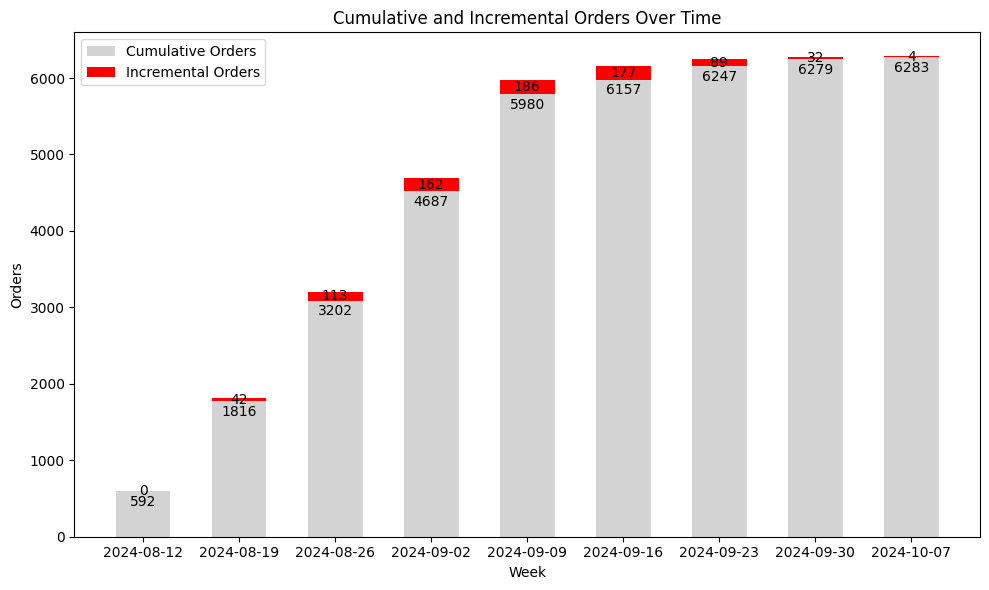

In [298]:
retention_df = create_retention_d(dps_all)
forecast_retention_df = estimated_retained_customers(dps_all, retention_df)
forecast_df = impact_summary(forecast_retention_df)
forecast_df_final = impact_summary_w_cost(dps_all, forecast_df)

plot_cumulative_incremental_profit(forecast_df_final)
plot_cumulative_incremental_orders(forecast_df_final)


In [300]:
analyze_city_orders(dps_new)

city_name_var,Helsinki-post,Oulu-post,Total
total_users,3829.0,886.0,4715.0
total_orders,3892.0,911.0,4803.0
total_completed_orders,3802.0,890.0,4692.0
voucher_based_orders,1079.0,268.0,1347.0
orders_per_user,1.02,1.03,1.02
c_orders_per_user,0.99,1.0,1.0
actual_delivery_fee_per_order,0.26,0.28,0.27
forgone_delivery_fee_per_order,3.46,3.66,3.54
voucher_eur_per_order,3.92,4.06,4.04
acquistion_cost_per_order,7.38,7.52,7.58


In [303]:
adjusted_df = dps_new.groupby('week').agg({'customer_account_id':'nunique','completed_orders':'sum','fully_loaded_gross_profit_eur':'sum','foregone_delivery_fee':'sum','voucher_amount_eur':'sum'}).reset_index()
adjusted_df['total_users'] = adjusted_df['customer_account_id'].sum()

adjusted_df['percentage_total'] = adjusted_df['customer_account_id'] / adjusted_df['total_users']
adjusted_df['c_orders_per_user_adjusted'] = adjusted_df['completed_orders'] / adjusted_df['customer_account_id']
adjusted_df['flgpo_adjusted'] = adjusted_df['fully_loaded_gross_profit_eur'] / adjusted_df['customer_account_id']
adjusted_df['total_cost'] = adjusted_df['voucher_amount_eur'] + adjusted_df['foregone_delivery_fee']
adjusted_df['cost_per_order'] = adjusted_df['total_cost'] / adjusted_df['customer_account_id']
 
adjusted_df['adjusted_customers'] = adjusted_df['percentage_total'] * (4715 * (1 + 0.44))

adjusted_df = adjusted_df[['week','adjusted_customers','c_orders_per_user_adjusted','flgpo_adjusted','cost_per_order']]

seasonal_ret = retention_df[['flgpo','orders_per_user','retention_rate']]

# Repeat the adjusted and retention dataframes and concatenate them
seasonal_df = pd.concat([adjusted_df.loc[adjusted_df.index.repeat(len(seasonal_ret))].reset_index(drop=True),
                                     pd.concat([seasonal_ret] * len(adjusted_df)).reset_index(drop=True)], axis=1)

# Sorting the DataFrame by 'week'
seasonal_df = seasonal_df.sort_values(by='week').reset_index(drop=True)

seasonal_df['final_customers'] = round(seasonal_df['adjusted_customers'] * seasonal_df['retention_rate']/100,0)

seasonal_df['total_orders'] = seasonal_df.apply(
    lambda row: row['orders_per_user'] * row['final_customers'] if row['retention_rate'] == 100 else row['orders_per_user'] * row['final_customers'],
    axis=1
)

seasonal_df['flgp'] = seasonal_df.apply(
    lambda row: row['total_orders'] * row['flgpo'] if row['retention_rate'] == 100 else row['total_orders'] * row['flgpo'],
    axis=1
)

# Ensure the 'week' column is in datetime format
seasonal_df['week'] = pd.to_datetime(seasonal_df['week'])

# Group by block of 5 rows and increment weeks correctly
seasonal_df['week'] = seasonal_df.groupby(seasonal_df.index // 5)['week'].transform(lambda x: x + pd.to_timedelta(range(len(x)), unit='W'))

# Now display the DataFrame
seasonal_df

final_df = seasonal_df.groupby('week').agg({'flgp':'sum','total_orders':'sum'}).reset_index()

final_df['flgp_cum'] = final_df['flgp'].cumsum()
final_df['orders_cum'] = final_df['total_orders'].cumsum()

final_df

,week,flgp,total_orders,flgp_cum,orders_cum
0,2024-08-12,-5436.9792,839.04,-5436.9792,839.04
1,2024-08-19,-10953.9600,1738.74,-16390.9392,2577.78
2,2024-08-26,-133.5348,168.28,-16524.4740,2746.06
3,2024-09-02,-12050.0218,2009.29,-28574.4958,4755.35
4,2024-09-09,-10242.6994,1824.98,-38817.1952,6580.33
5,2024-09-16,-266.5556,335.80,-39083.7508,6916.13
6,2024-09-23,-11612.5986,1916.91,-50696.3494,8833.04
7,2024-09-30,10.2466,44.94,-50686.1028,8877.98
8,2024-10-07,1.1220,6.60,-50684.9808,8884.58


In [308]:
(adjusted_df['adjusted_customers'] * adjusted_df['c_orders_per_user_adjusted'] * adjusted_df['cost_per_order']).sum()

50270.511326853295

In [309]:
-50684.9808	 / 50270.511326853295

-1.0082447833174377

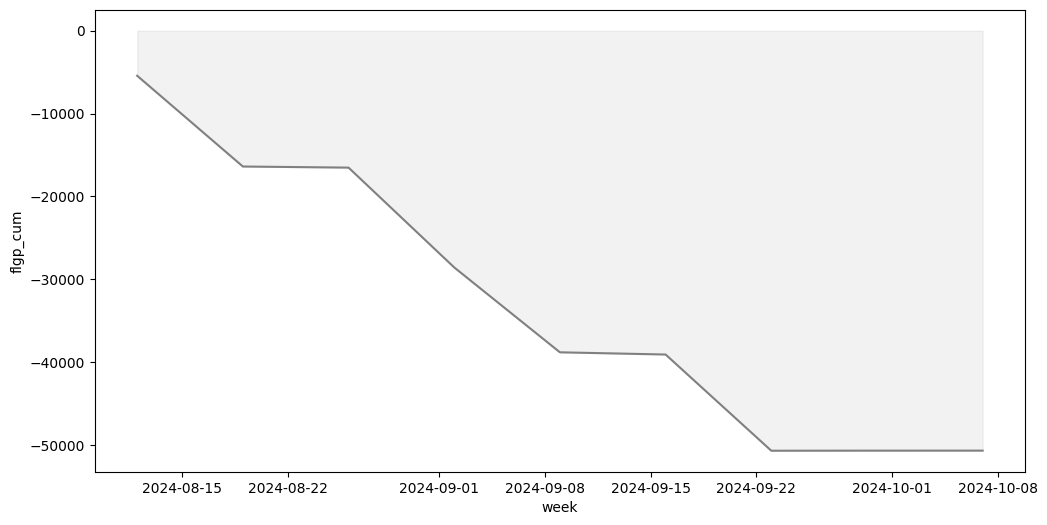

In [304]:
# Set the figure size (width, height)
plt.figure(figsize=(12, 6))

# Plot the lineplot with a darker color
sns.lineplot(data=final_df, x='week', y='flgp_cum', color='grey')  # Darker teal for the line

# Fill the area under the line with a lighter color
plt.fill_between(final_df['week'], final_df['flgp_cum'], color='grey', alpha=0.1)  # Lighter teal for the fill

# Display the plot
plt.show()

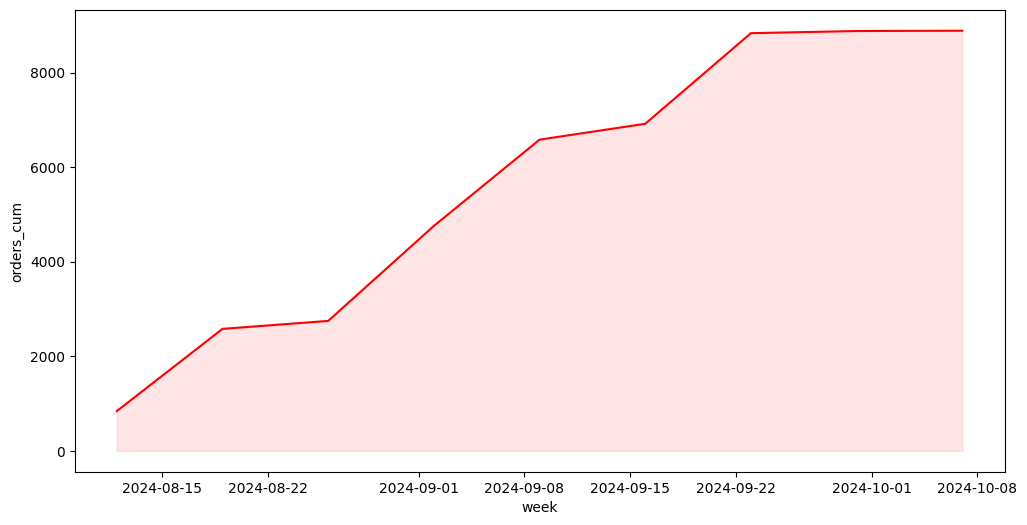

In [305]:
# Set the figure size (width, height)
plt.figure(figsize=(12, 6))

# Plot the lineplot with a darker color
sns.lineplot(data=final_df, x='week', y='orders_cum', color='red')  # Darker teal for the line

# Fill the area under the line with a lighter color
plt.fill_between(final_df['week'], final_df['orders_cum'], color='red', alpha=0.1)  # Lighter teal for the fill

# Display the plot
plt.show()

# Voucher Analysis

In [280]:
city = ('Tampere','Turku')
city_str = ",".join([f"'{c}'" for c in city])

voucher_new = client.query(voucher_new_v(city_str)).to_dataframe()
voucher_all = client.query(voucher_all_v(city_str)).to_dataframe()

In [281]:
tmp = voucher_new[['platform_order_code','voucher_code','voucher_amount_eur']]
tmp2 = voucher_all.drop(columns=['voucher_code', 'voucher_amount_eur'])

voucher_all = pd.merge(tmp2,tmp , on = 'platform_order_code',how = 'left')

In [282]:
### VOUCHER ANALYSIS NEW CUSTOMERS ###

## missing values ##
missing_value_before = voucher_new.isna().sum()
missing_columns_before = missing_value_before[missing_value_before != 0]

print(missing_columns_before)

columns_to_fill = ['voucher_amount_eur','delivery_costs_eur','delivery_distance']

voucher_new[columns_to_fill] = voucher_new[columns_to_fill].fillna(0)

missing_value_after = voucher_new.isna().sum()
missing_columns_after =  missing_value_after[missing_value_after != 0]

print(missing_columns_after)


## summary of first order data ###

# first order ##

voucher_new = handle_customer_first_order_date(voucher_new)

## DATA CHECKS ##
print(f'Are there any users with orders with 0 DPS delivery fee before the intervention date?', {check_first_order_before_intervention(voucher_new)})
print(f'Are there any users with multiple orders as characterized as new customer first time order?', {check_duplicate_orders(voucher_new)})
print(f'Are there any orders with 0 delivery fee which will be used to assess the cost?',{check_zero_delivery_fee(voucher_new)})
print(F'How many orders had both free delivery and vouchers?',{count_orders_with_vouchers(voucher_new)})


### convert numeric data to float ###

columns_to_convert = ['dps_delivery_fee_eur',
       'delivery_fee_eur', 'delivery_fee_local', 'dps_travel_time_fee_eur',
       'dps_standard_fee_eur', 'vendor_funding_amount_local',
       'dps_last_non_zero_df_eur', 'delivery_fee_vat_eur',
       'delivery_fee_vat_local', 'delivery_fee_option', 'priority_fee_eur',
       'saver_discount_eur', 'gfv_eur', 'gfv_local', 'gmv_eur', 'gmv_local',
       'profit_eur', 'profit_local', 'revenue_eur', 'revenue_local',
       'mov_customer_fee_eur', 'service_fee_eur', 'dps_service_fee_eur',
       'delivery_distance', 'delivery_costs_eur', 'delivery_costs_local',
       'joker_vendor_fee_eur','completed_orders', 'fully_loaded_gross_profit_eur', 'commission_eur',
        'voucher_amount_eur']

voucher_new[columns_to_convert] = voucher_new[columns_to_convert].apply(pd.to_numeric, errors='coerce').astype(float)

analyze_city_orders(voucher_new)

customer_first_order_date      573
dps_delivery_fee_eur             4
dps_travel_time_fee_eur          4
dps_standard_fee_eur           526
vendor_funding_amount_local    573
dps_last_non_zero_df_eur         4
delivery_fee_option              8
saver_discount_eur             564
dps_service_fee_eur              4
new_customer_condition_type    573
voucher_amount_eur               2
dtype: int64
customer_first_order_date      573
dps_delivery_fee_eur             4
dps_travel_time_fee_eur          4
dps_standard_fee_eur           526
vendor_funding_amount_local    573
dps_last_non_zero_df_eur         4
delivery_fee_option              8
saver_discount_eur             564
dps_service_fee_eur              4
new_customer_condition_type    573
dtype: int64
Are there any users with orders with 0 DPS delivery fee before the intervention date? {'no'}
Are there any users with multiple orders as characterized as new customer first time order? {11}
Are there any orders with 0 delivery fee which wi

city_name_var,Tampere-post,Turku-post,Total
total_users,305.0,256.0,561.0
total_orders,312.0,261.0,573.0
total_completed_orders,312.0,261.0,573.0
voucher_based_orders,312.0,261.0,573.0
orders_per_user,1.02,1.02,1.02
c_orders_per_user,1.02,1.02,1.02
actual_delivery_fee_per_order,3.48,3.48,3.46
forgone_delivery_fee_per_order,0.12,0.26,0.18
voucher_eur_per_order,13.51,13.61,13.56
acquistion_cost_per_order,13.63,13.87,13.74


In [283]:
### Voucher ANALYSIS ALL CUSTOMERS ###

## missing values ##
missing_value_before = voucher_all.isna().sum()
missing_columns_before = missing_value_before[missing_value_before != 0]

print(missing_columns_before)

columns_to_fill = ['voucher_amount_eur','delivery_costs_eur','delivery_distance']

voucher_all[columns_to_fill] = voucher_all[columns_to_fill].fillna(0)

missing_value_after = voucher_all.isna().sum()
missing_columns_after =  missing_value_after[missing_value_after != 0]

print(missing_columns_after)


## summary of first order data ###

# first order ##

voucher_all = handle_customer_first_order_date(voucher_all)

## DATA CHECKS ##
print(f'Are there any users with orders with 0 DPS delivery fee before the intervention date?', {check_first_order_before_intervention(voucher_all)})
print(f'Are there any orders with 0 delivery fee which will be used to assess the cost?',{check_zero_delivery_fee(voucher_all)})
print(F'How many orders had both free delivery and vouchers?',{count_orders_with_vouchers(voucher_all)})


### convert numeric data to float ###

columns_to_convert = ['dps_delivery_fee_eur',
       'delivery_fee_eur', 'delivery_fee_local', 'dps_travel_time_fee_eur',
       'dps_standard_fee_eur', 'vendor_funding_amount_local',
       'dps_last_non_zero_df_eur', 'delivery_fee_vat_eur',
       'delivery_fee_vat_local', 'delivery_fee_option', 'priority_fee_eur',
       'saver_discount_eur', 'gfv_eur', 'gfv_local', 'gmv_eur', 'gmv_local',
       'profit_eur', 'profit_local', 'revenue_eur', 'revenue_local',
       'mov_customer_fee_eur', 'service_fee_eur', 'dps_service_fee_eur',
       'delivery_distance', 'delivery_costs_eur', 'delivery_costs_local',
       'joker_vendor_fee_eur','completed_orders', 'fully_loaded_gross_profit_eur', 'commission_eur',
        'voucher_amount_eur']

voucher_all[columns_to_convert] = voucher_all[columns_to_convert].apply(pd.to_numeric, errors='coerce').astype(float)

voucher_post = voucher_all[voucher_all['voucher_code'].isna()]

analyze_city_orders(voucher_post)

customer_first_order_date      760
dps_delivery_fee_eur             6
dps_travel_time_fee_eur          6
dps_standard_fee_eur           657
vendor_funding_amount_local    760
dps_last_non_zero_df_eur         6
delivery_fee_option             12
saver_discount_eur             751
dps_service_fee_eur              6
delivery_distance                9
delivery_costs_eur               4
delivery_costs_local             4
new_customer_condition_type    760
voucher_code                   187
voucher_amount_eur             189
dtype: int64
customer_first_order_date      760
dps_delivery_fee_eur             6
dps_travel_time_fee_eur          6
dps_standard_fee_eur           657
vendor_funding_amount_local    760
dps_last_non_zero_df_eur         6
delivery_fee_option             12
saver_discount_eur             751
dps_service_fee_eur              6
delivery_costs_local             4
new_customer_condition_type    760
voucher_code                   187
dtype: int64
Are there any users with orde

/var/folders/7c/hjrbzbpn61jgnsn14y5f3l7c0000gq/T/ipykernel_30934/189176572.py:351: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['foregone_delivery_fee'] = df['dps_standard_fee_eur'].where(
/var/folders/7c/hjrbzbpn61jgnsn14y5f3l7c0000gq/T/ipykernel_30934/189176572.py:354: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['voucher_amount_eur'] = df['voucher_amount_eur'].where(df['is_sent'], 0)
/var/folders/7c/hjrbzbpn61jgnsn14y5f3l7c0000gq/T/ipykernel_30934/189176572.py:355: SettingWithCopyWarning: 
A valu

city_name_var,Tampere-post,Turku-post,Total
total_users,59.0,53.0,112.0
total_orders,93.0,94.0,187.0
total_completed_orders,86.0,86.0,172.0
voucher_based_orders,0.0,0.0,0.0
orders_per_user,1.58,1.77,1.67
c_orders_per_user,1.46,1.62,1.54
actual_delivery_fee_per_order,2.62,1.83,2.39
forgone_delivery_fee_per_order,0.41,0.67,0.57
voucher_eur_per_order,0.0,0.0,0.0
acquistion_cost_per_order,0.41,0.64,0.57


/var/folders/7c/hjrbzbpn61jgnsn14y5f3l7c0000gq/T/ipykernel_30934/189176572.py:534: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['created_date_local'] = pd.to_datetime(df['created_date_local'])
/var/folders/7c/hjrbzbpn61jgnsn14y5f3l7c0000gq/T/ipykernel_30934/189176572.py:536: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['first_order_date'] = df.groupby('customer_account_id')['created_date_local'].transform('min')
/var/folders/7c/hjrbzbpn61jgnsn14y5f3l7c0000gq/T/ipykernel_30934/189176572.py:538: Setti

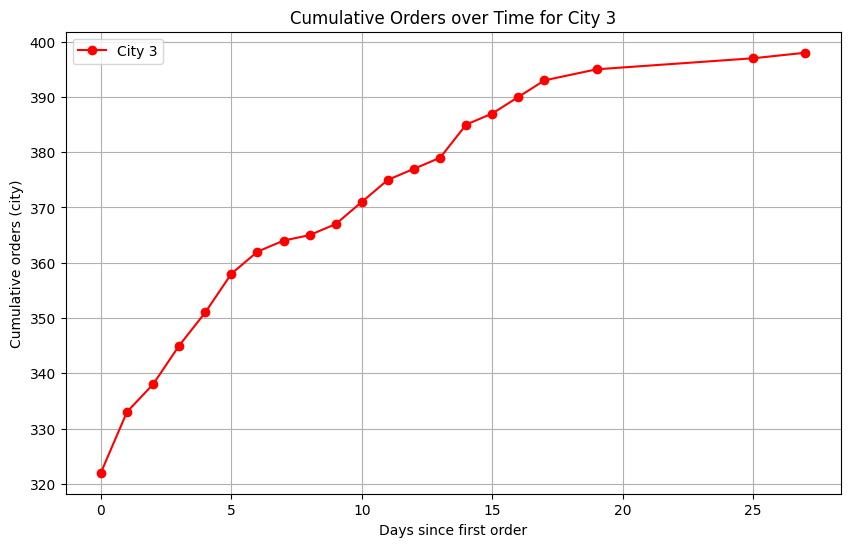

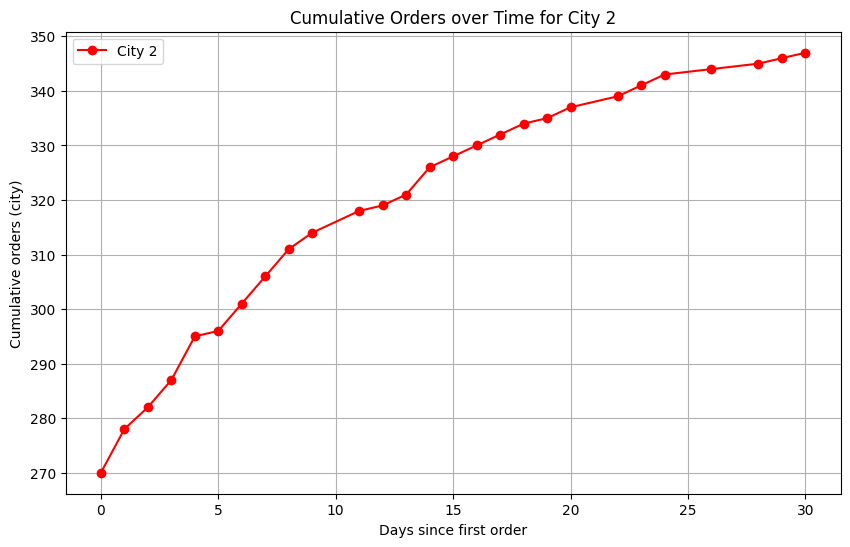

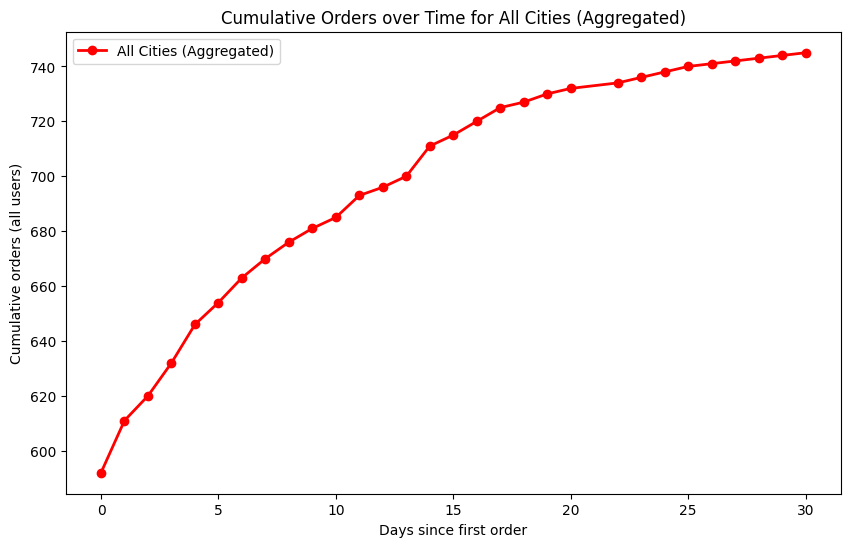

In [284]:
plot_cumulative_orders_by_city(voucher_all)

In [285]:
def create_retention_d_v(df):
   
    post_inter_df = df[df['is_sent'] == True].copy()

    post_inter_df['first_order_date'] = post_inter_df.groupby('customer_account_id')['created_date_local'].transform('min')

    post_inter_df['week_diff'] = ((post_inter_df['created_date_local'] - post_inter_df['first_order_date']).dt.days // 7)

    total_users = post_inter_df['customer_account_id'].nunique()

    retention_df = post_inter_df.groupby('week_diff').agg(
        users_retained=('customer_account_id', 'nunique'),
        orders_made=('completed_orders', 'sum'),
        profit_made=('profit_eur', 'sum'),
        flgp=('fully_loaded_gross_profit_eur', 'sum')
    )

    retention_df['retention_rate'] = (retention_df['users_retained'] / total_users) * 100
    retention_df['orders_per_user'] = (retention_df['orders_made'] / retention_df['users_retained'])
    retention_df['profit_per_order'] = (retention_df['profit_made'] / retention_df['orders_made'])
    retention_df['flgpo'] = (retention_df['flgp'] / retention_df['orders_made'])

    x = retention_df.index
    y = retention_df['retention_rate']

    plt.figure(figsize=(10, 6))
    plt.plot(x, y, marker='o', color='red', linestyle='-')

    for i in range(len(x)):
        plt.text(i, y[i] + 1.5, round(y[i], 2), ha='center', va='bottom')

    plt.xlabel('Weeks Since First Order', fontsize=12)
    plt.ylabel('Retention Rate (%)', fontsize=12)
    plt.title('Week-over-Week User Retention', fontsize=14)
    plt.grid(False)
    plt.xticks(retention_df.index)
    plt.show()

    retention_df = retention_df.round(2).reset_index()

    return retention_df

def estimated_retained_customers_v(df, r_df, week_diff_range=5):
  
    weekly_new_customers = df.groupby('week').agg(
        new_customers=('customer_account_id', lambda x: np.sum(~df.loc[x.index, 'voucher_code'].isna())
    )).reset_index()

    long_form_retained_customers = pd.DataFrame()

    # Loop over the week_diff range to calculate the retention impact for each week
    for i in range(0, week_diff_range):
        temp_df = weekly_new_customers.copy()
        temp_df['week_diff'] = i
        temp_df['Retained_Customers'] = round(
            temp_df['new_customers'] * ((r_df.loc[r_df['week_diff'] == i, 'retention_rate'].values[0]) / 100), 0
        )
        temp_df['Orders_per_User'] = r_df.loc[r_df['week_diff'] == i, 'orders_per_user'].values[0]
        temp_df['Profit_per_Order'] = r_df.loc[r_df['week_diff'] == i, 'profit_per_order'].values[0]
        temp_df['flgp_per_order'] = r_df.loc[r_df['week_diff'] == i, 'flgpo'].values[0]

        # Calculate total orders, total profit, and FLGP
        temp_df['Total_Orders'] = temp_df['Retained_Customers'] * temp_df['Orders_per_User']
        temp_df['Total_Profit'] = temp_df['Total_Orders'] * temp_df['Profit_per_Order']
        temp_df['FLGP'] = temp_df['Total_Orders'] * temp_df['flgp_per_order']

        # Concatenate results
        long_form_retained_customers = pd.concat([long_form_retained_customers, temp_df], ignore_index=True)

    # Select the relevant columns
    long_form_retained_customers = long_form_retained_customers[['week', 'new_customers', 'week_diff', 'Retained_Customers',
                                                                 'Orders_per_User', 'Profit_per_Order', 'flgp_per_order',
                                                                 'Total_Orders', 'Total_Profit', 'FLGP']]

    # Convert week column to datetime and calculate final week
    long_form_retained_customers['week'] = pd.to_datetime(long_form_retained_customers['week'])
    long_form_retained_customers['final_week'] = long_form_retained_customers['week'] + pd.to_timedelta(long_form_retained_customers['week_diff'] * 7, unit='D')

    return long_form_retained_customers



def impact_summary(df):
    
    # Group by 'final_week' and calculate aggregate and incremental metrics
    total_impact = df.groupby('final_week').agg(
        Total_Orders=('Total_Orders', 'sum'), 
        Total_Profit=('Total_Profit', 'sum'),
        Total_FLGP=('FLGP', 'sum'),
        incremental_orders=('Total_Orders', lambda x: x[df.loc[x.index, 'week_diff'].isin([1, 2, 3, 4, 5])].sum()),
        incremental_profit=('Total_Profit', lambda x: x[df.loc[x.index, 'week_diff'].isin([1, 2, 3, 4, 5])].sum()),
        incremental_flgp=('FLGP', lambda x: x[df.loc[x.index, 'week_diff'].isin([1, 2, 3, 4, 5])].sum())
    ).reset_index()
    
    # Calculate cumulative values
    total_impact['total_orders_cum'] = total_impact['Total_Orders'].cumsum()
    total_impact['total_profit_cum'] = total_impact['Total_Profit'].cumsum()
    total_impact['total_flgp_cum'] = total_impact['Total_FLGP'].cumsum()
    
    return total_impact


def impact_summary_w_cost(df, df1):

    cost_df = df.copy()

    cost_df['foregone_delivery_fee'] = cost_df.apply(
        lambda row: row['dps_standard_fee_eur'] if row['dps_delivery_fee_eur'] == 0 or pd.isnull(row['dps_delivery_fee_eur']) else 0,
        axis=1
    )

    w_cost_df = cost_df.groupby('week').agg({
        'foregone_delivery_fee': 'sum',
        'voucher_amount_eur': 'sum'
    }).reset_index()

    w_cost_df['total_cost'] = w_cost_df['foregone_delivery_fee']

    w_cost_df.rename(columns={'week': 'final_week'}, inplace=True)

    w_cost_df['final_week'] = pd.to_datetime(w_cost_df['final_week'])
    df1['final_week'] = pd.to_datetime(df1['final_week'])

    final_df = pd.merge(df1, w_cost_df, on='final_week', how='left')

    final_df['total_cost'] = final_df['total_cost'].astype(float)
    final_df.fillna(0, inplace=True)

    final_df['total_cost_cum'] = final_df['total_cost'].cumsum()


    return final_df



def plot_cumulative_incremental_profit(df):
    plt.figure(figsize=(10, 6))

    bars1 = plt.bar(df['final_week'], df['total_flgp_cum'], label='Cumulative Profit', width=4, align='center', color='lightgrey')

    bars2 = plt.bar(df['final_week'], df['incremental_profit'], label='Incremental Profit', width=4, align='center',
                    bottom=np.where(df['total_flgp_cum'] >= 0, df['total_flgp_cum'], df['total_flgp_cum']),
                    color='red')

    for i, bar in enumerate(bars1):
        height = bar.get_height()

        if not np.isnan(height):
            if height < 0:
                plt.text(bar.get_x() + bar.get_width() / 2.0, height - 100, f'{int(height)}',
                         ha='center', va='top', color='black')
            else:
                plt.text(bar.get_x() + bar.get_width() / 2.0, height + 100, f'{int(height)}',
                         ha='center', va='top', color='black')

    for i, bar in enumerate(bars2):
        height = bar.get_height()
        bottom = bar.get_y()

        if not np.isnan(height):
            plt.text(bar.get_x() + bar.get_width() / 2.0, bottom + height / 2, f'{int(abs(height))}',
                     ha='center', va='center', color='white')

    plt.title('Cumulative and Incremental Profit Over Time')
    plt.xlabel('Week')
    plt.ylabel('Profit (€)')

    plt.xticks(df['final_week'])

    ymin = df[['total_flgp_cum', 'incremental_profit']].min().min() - 3000
    ymax = df[['total_flgp_cum', 'incremental_profit']].max().max() + 3000

    plt.ylim(ymin, ymax)
    plt.yticks(np.arange(np.floor(ymin / 1000) * 1000, np.ceil(ymax / 1000) * 1000, 1000))

    plt.legend()
    plt.tight_layout()
    plt.show()


def plot_cumulative_incremental_orders(df):
    plt.figure(figsize=(10, 6))

    bars1 = plt.bar(df['final_week'], df['total_orders_cum'], width=4, align='center', label='Cumulative Orders', color='lightgrey')

    bars2 = plt.bar(df['final_week'], df['incremental_orders'], width=4, align='center', label='Incremental Orders', 
                    bottom=df['total_orders_cum'] - df['incremental_orders'], color='red')

    for i, bar in enumerate(bars1):
        height = bar.get_height()
        incremental_height = df['incremental_orders'].iloc[i]

        if not np.isnan(height) and not np.isnan(incremental_height):
            plt.text(bar.get_x() + bar.get_width() / 2.0, height - incremental_height - 50,
                     f'{int(height)}', ha='center', va='top', color='black')

    for i, bar in enumerate(bars2):
        height = bar.get_height()
        bottom = bar.get_y()

        if not np.isnan(height):
            plt.text(bar.get_x() + bar.get_width() / 2.0, bottom + height / 2, f'{int(height)}', ha='center', va='center', color='white')

    plt.title('Cumulative and Incremental Orders Over Time')
    plt.xlabel('Week')
    plt.ylabel('Orders')

    plt.xticks(df['final_week'])

    plt.legend()
    plt.tight_layout() 
    plt.show()

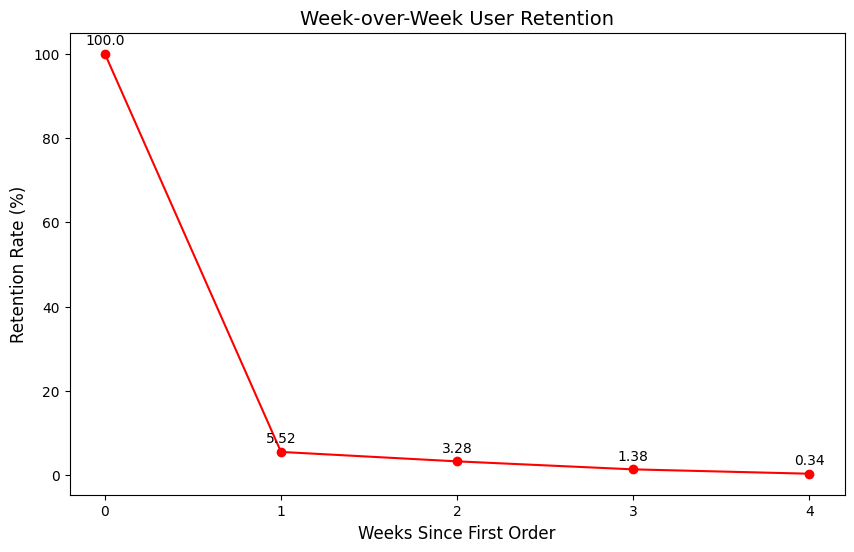

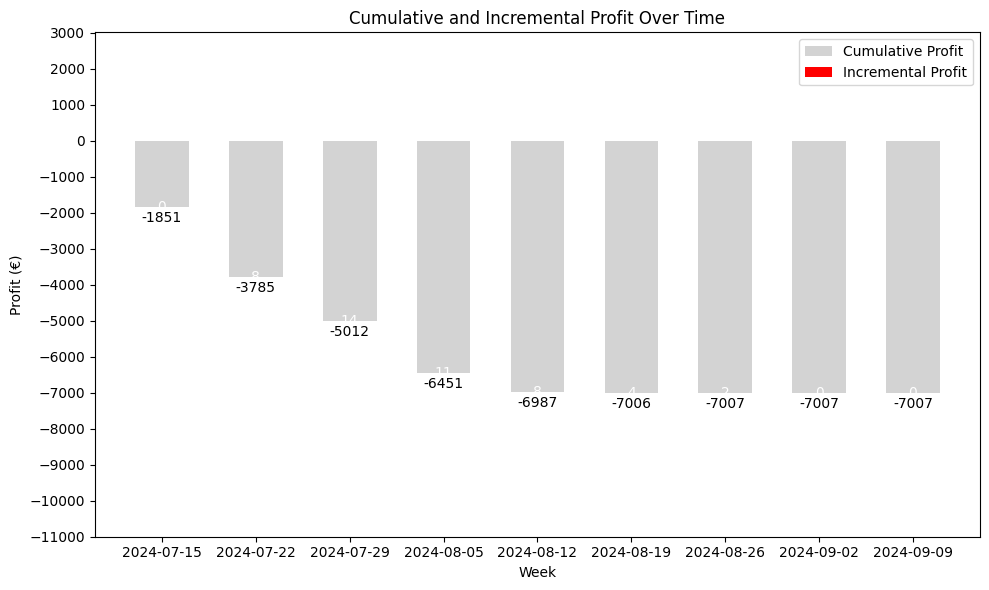

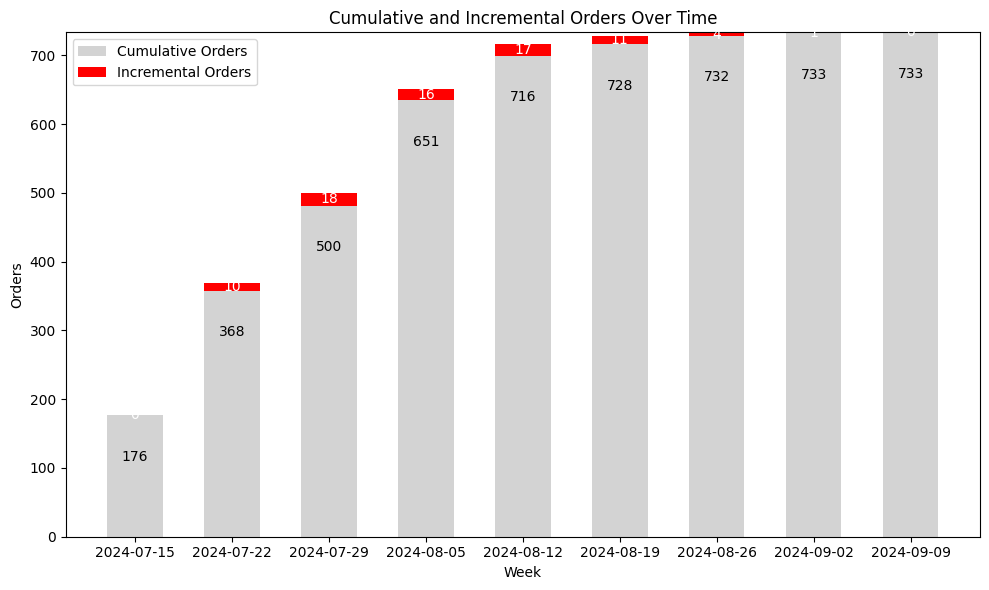

In [286]:
retention_df = create_retention_d_v(voucher_all)
forecast_retention_df = estimated_retained_customers_v(voucher_all, retention_df,len(retention_df))
forecast_df = impact_summary(forecast_retention_df)
forecast_df_final = impact_summary_w_cost(voucher_all, forecast_df)

plot_cumulative_incremental_profit(forecast_df_final)
plot_cumulative_incremental_orders(forecast_df_final)